## Read 2pt for test

In [29]:
import numpy as np
import gvar as gv

from lametlat.utils.plot_settings import *
from lametlat.preprocess.read_raw import pt2_to_meff, pt2_to_meff_solve
from lametlat.utils.resampling import bootstrap, bs_ls_avg
from lametlat.gsfit.Lanczos.t_matrix import T_Matrix
from lametlat.utils.constants import *
from lametlat.utils.funcs import constant_fit

a = 0.04
pt2_data = np.loadtxt("data/c2pt.CG52bxp00_CG52bxp00.SS.meson_g15.PX0_PY0_PZ0.real", delimiter=',')
print(np.shape(pt2_data))
pt2_data = pt2_data.swapaxes(0, 1)[1:] # remove the first row, which is the time
pt2_bs, _ = bootstrap(pt2_data, samp_times=100, bin=5)
print(np.shape(pt2_bs))

(64, 315)
(100, 64)


0.13944(56)


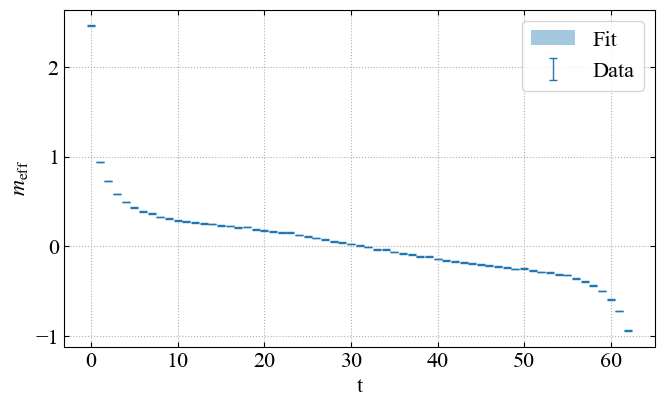

In [39]:
# meff_bs = [pt2_to_meff_solve(pt2_bs[i], boundary="periodic") for i in range(len(pt2_bs))]
meff_bs = [pt2_to_meff(pt2_bs[i], boundary="none") for i in range(len(pt2_bs))]
meff_avg = bs_ls_avg(meff_bs) * GEV_FM / a

# Clean NaN values in meff_avg
meff_avg = np.array([x if not np.isnan(x.mean) else gv.gvar(0, 10) for x in meff_avg])

fit_res = constant_fit(meff_avg[15:30])

print(fit_res)

fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.fill_between(np.arange(len(meff_avg)), gv.mean(fit_res) - gv.sdev(fit_res), gv.mean(fit_res) + gv.sdev(fit_res), alpha=0.4, label='Fit')
ax.set_xlabel('t', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$', **fs_p)
# plt.ylim(0.2, 0.6)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

In [12]:



for n_conf in range(len(pt2_bs)):
    pt2_norm = pt2_bs[n_conf] / pt2_bs[n_conf][0]
    for m in range(3, 15):
        t_matrix_class = T_Matrix(pt2_norm, m=m)
        t_matrix = t_matrix_class.main(ifcheck=False)





t_matrix_class = T_Matrix(pt2_norm, m=6)
t_matrix = t_matrix_class.main()

# Calculate eigenvalues of the t_matrix
eigenvalues = np.linalg.eigvals(t_matrix)

print("Eigenvalues of the t_matrix:")
print(eigenvalues)

energy_states = - GEV_FM / a * np.log( eigenvalues )
energy_states = np.array([e for e in energy_states if not np.isnan(e)])
energy_states = np.sort(energy_states)

print(">>> Ground state energy: ", energy_states[0], " GeV")

Eigenvalues of the t_matrix:
[-1.36749784e+00  9.14373033e-01  5.59940942e-01  1.56822060e-03
  3.12764551e-02 -1.06533635e+03]
>>> Ground state energy:  0.29440083769987413  GeV


/tmp/ipykernel_2210867/204689197.py:10: RuntimeWarning: invalid value encountered in log
  energy_states = - GEV_FM / a * np.log( eigenvalues )


## Check with Xiang

(516, 64)
>>> Ground state energy:  1.3290707636698544  GeV
>>> Ground state energy:  1.3260925501300291  GeV
>>> Ground state energy:  1.3213640084311242  GeV
>>> Ground state energy:  0.9780731294884266  GeV
>>> Ground state energy:  1.3265643596338208  GeV
>>> Ground state energy:  1.249743627296297  GeV
>>> Ground state energy:  1.2627780302562244  GeV
>>> Ground state energy:  1.2726179570231155  GeV
>>> Ground state energy:  1.2159487164109128  GeV
>>> Ground state energy:  1.2461649289654835  GeV
>>> Ground state energy:  1.2265909910981896  GeV
>>> Ground state energy:  1.2359576936462306  GeV


/tmp/ipykernel_2210867/2602930046.py:30: RuntimeWarning: invalid value encountered in log
  energy_states = - GEV_FM / a * np.log( eigenvalues )


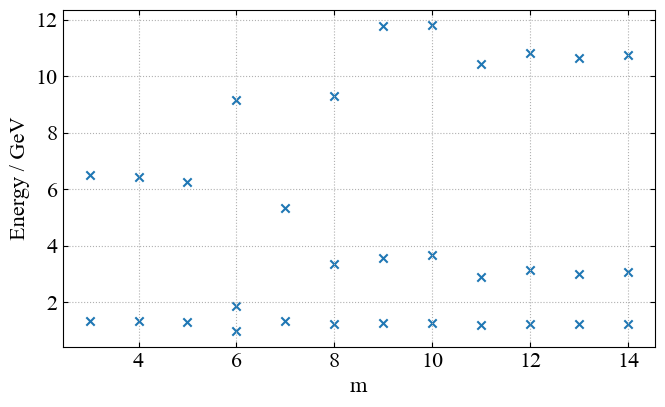

In [16]:
import numpy as np
from lametlat.utils.resampling import *

# Read the data file
data = np.loadtxt('data/c2pt.CG100bxyp00_CG100bxyp00.SS.proton_Upol.PX0_PY0_PZ0.real', delimiter=',')

data = data.swapaxes(0, 1)[1:]

print(np.shape(data))

bs_data, _ = bootstrap(data, samp_times=500)
pt2_samp = np.mean(bs_data, axis=0) # Take the mean

pt2_norm = pt2_samp / pt2_samp[0]  # normalize by the C(t=0)


m_ls = []
en_ls = []

for m in range(3, 15):
    t_matrix_class = T_Matrix(pt2_norm, m=m)
    t_matrix = t_matrix_class.main()

    # Calculate eigenvalues of the t_matrix
    eigenvalues = np.linalg.eigvals(t_matrix)

    # print("Eigenvalues of the t_matrix:")
    # print(eigenvalues)

    energy_states = - GEV_FM / a * np.log( eigenvalues )
    energy_states = np.array([e for e in energy_states if not np.isnan(e)])
    energy_states = np.sort(energy_states[energy_states > 0])
    
    en_ls.append(energy_states)
    m_ls.append(m * np.ones(len(energy_states)))

    print(">>> Ground state energy: ", energy_states[0], " GeV")
    
flat_m_ls = np.concatenate(m_ls)
flat_en_ls = np.concatenate(en_ls)
    

fig, ax = default_plot()
ax.scatter(flat_m_ls, flat_en_ls, marker='x')
ax.set_xlabel('m', **fs_p)
ax.set_ylabel('Energy / GeV', **fs_p)
plt.tight_layout()
plt.show()
